In [1]:
import datetime
import Factor_classes

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
# se togli i seguenti ticker da Tickers.json, la strategia migliore diventa random forest:
#"IG.MI", "LDO.MI", "REC.MI",
#"STLAM.MI", "STMMI.MI", "TRN.MI", 
#"AZM.MI", "BPSO.MI", "ERG.MI"

In [3]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stock_data = Factor_classes.StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,AZM.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,BPSO.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLAM.MI,STMMI.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,-0.036302,-0.057525,-0.034531,0.033469,-0.047368,-0.036450,-0.061018,0.036468,0.110658,-0.072374,...,-0.027754,-0.033333,-0.061186,0.065526,-0.057827,0.013154,0.028125,-0.053698,0.005291,-0.000776
2023-11-30,0.042084,-0.052874,-0.036249,0.063020,0.044890,-0.052813,0.064156,0.069334,0.051450,-0.068658,...,-0.024532,-0.008276,-0.032923,-0.009901,-0.115216,-0.021172,-0.170888,0.003616,0.042763,-0.006990
2023-12-31,0.117763,0.072312,0.120361,0.046110,0.004627,0.058610,0.217814,0.116129,0.108738,-0.040211,...,0.009145,0.023644,0.071792,0.110556,0.193681,0.081826,0.087169,0.026885,0.056572,0.035198


In [5]:
correlation_matrix = Factor_classes.CorrelationMatrix(returns)
#correlation_matrix.plot_heatmap()

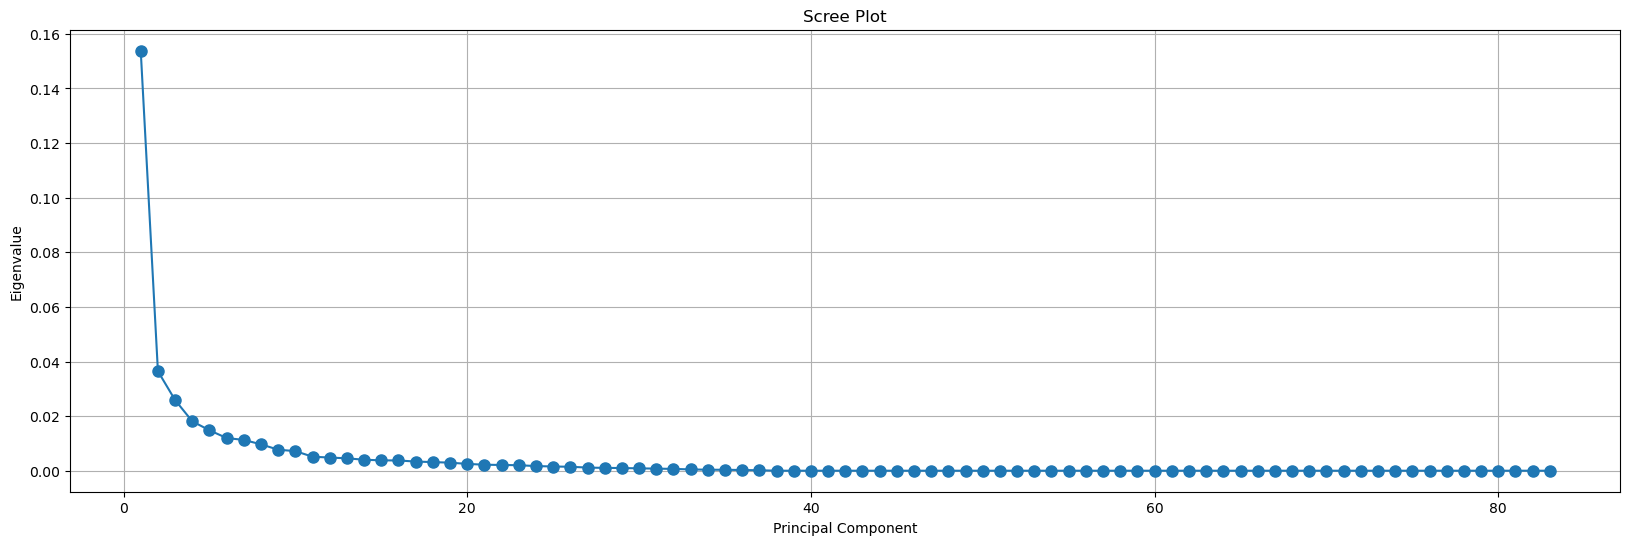

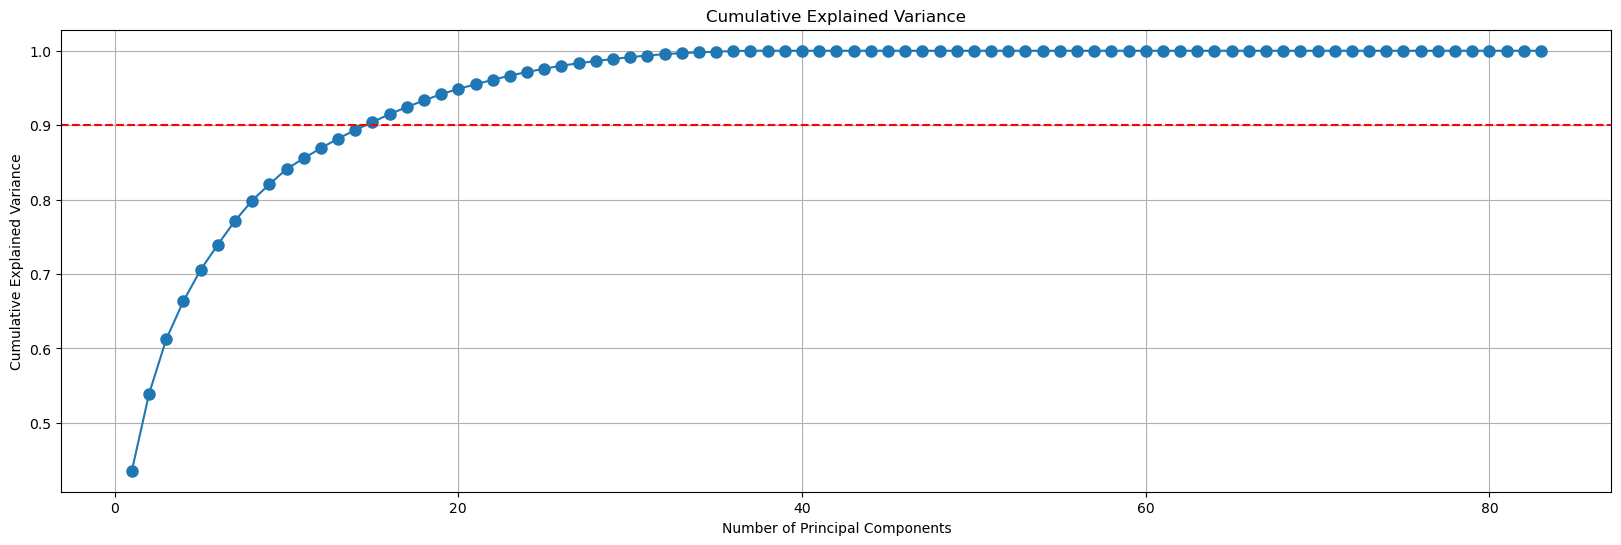

In [6]:
pca_analysis = Factor_classes.ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [7]:
"""
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final
"""

'\nm = 16 #explained variance 95\nwindow_size = 36\nmax_iterations = 10000\nfactor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)\n\nU_m_final = factor_model.U_m_final\nF_final = factor_model.F_final\nB_final = factor_model.B_final\n'

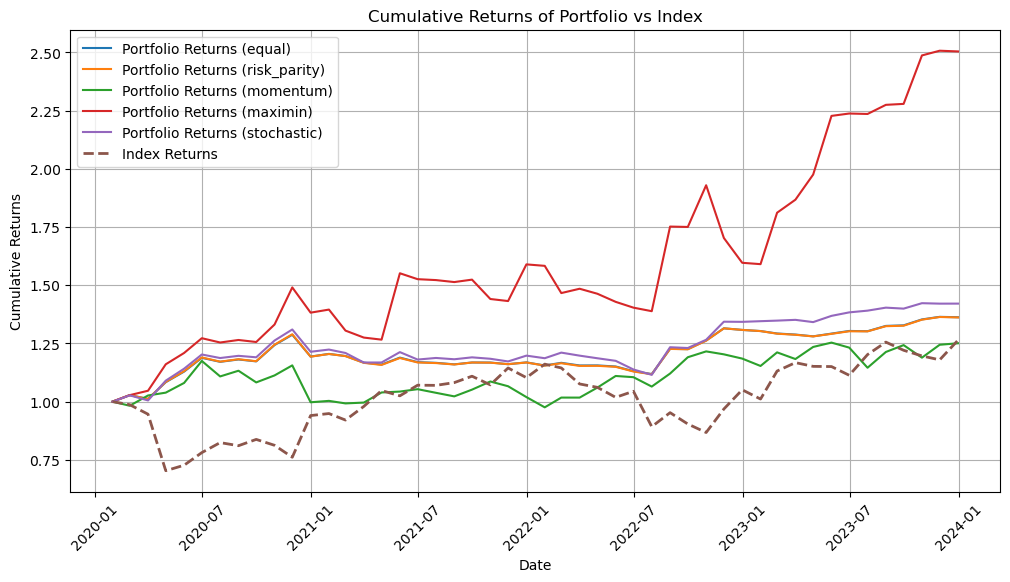

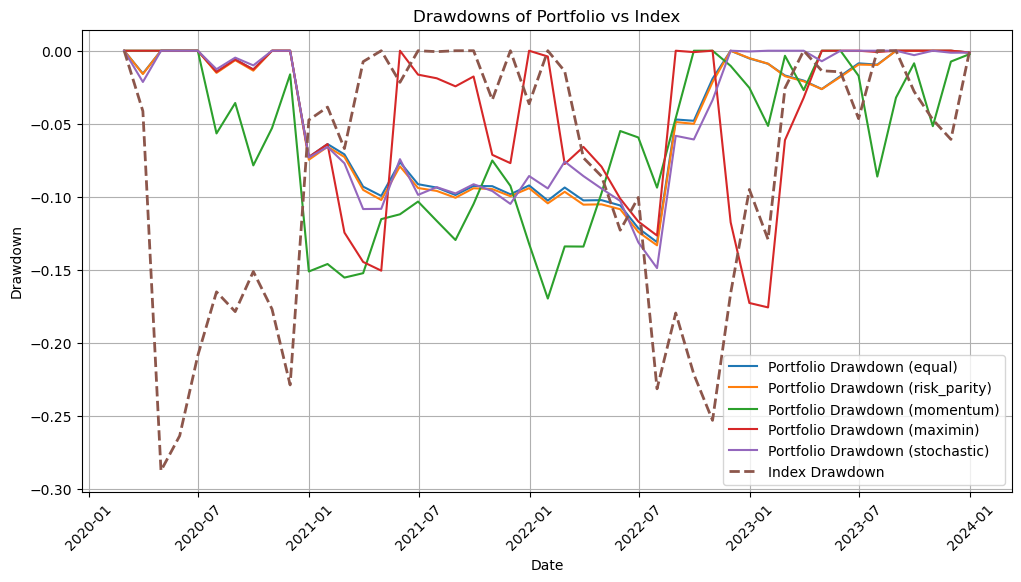

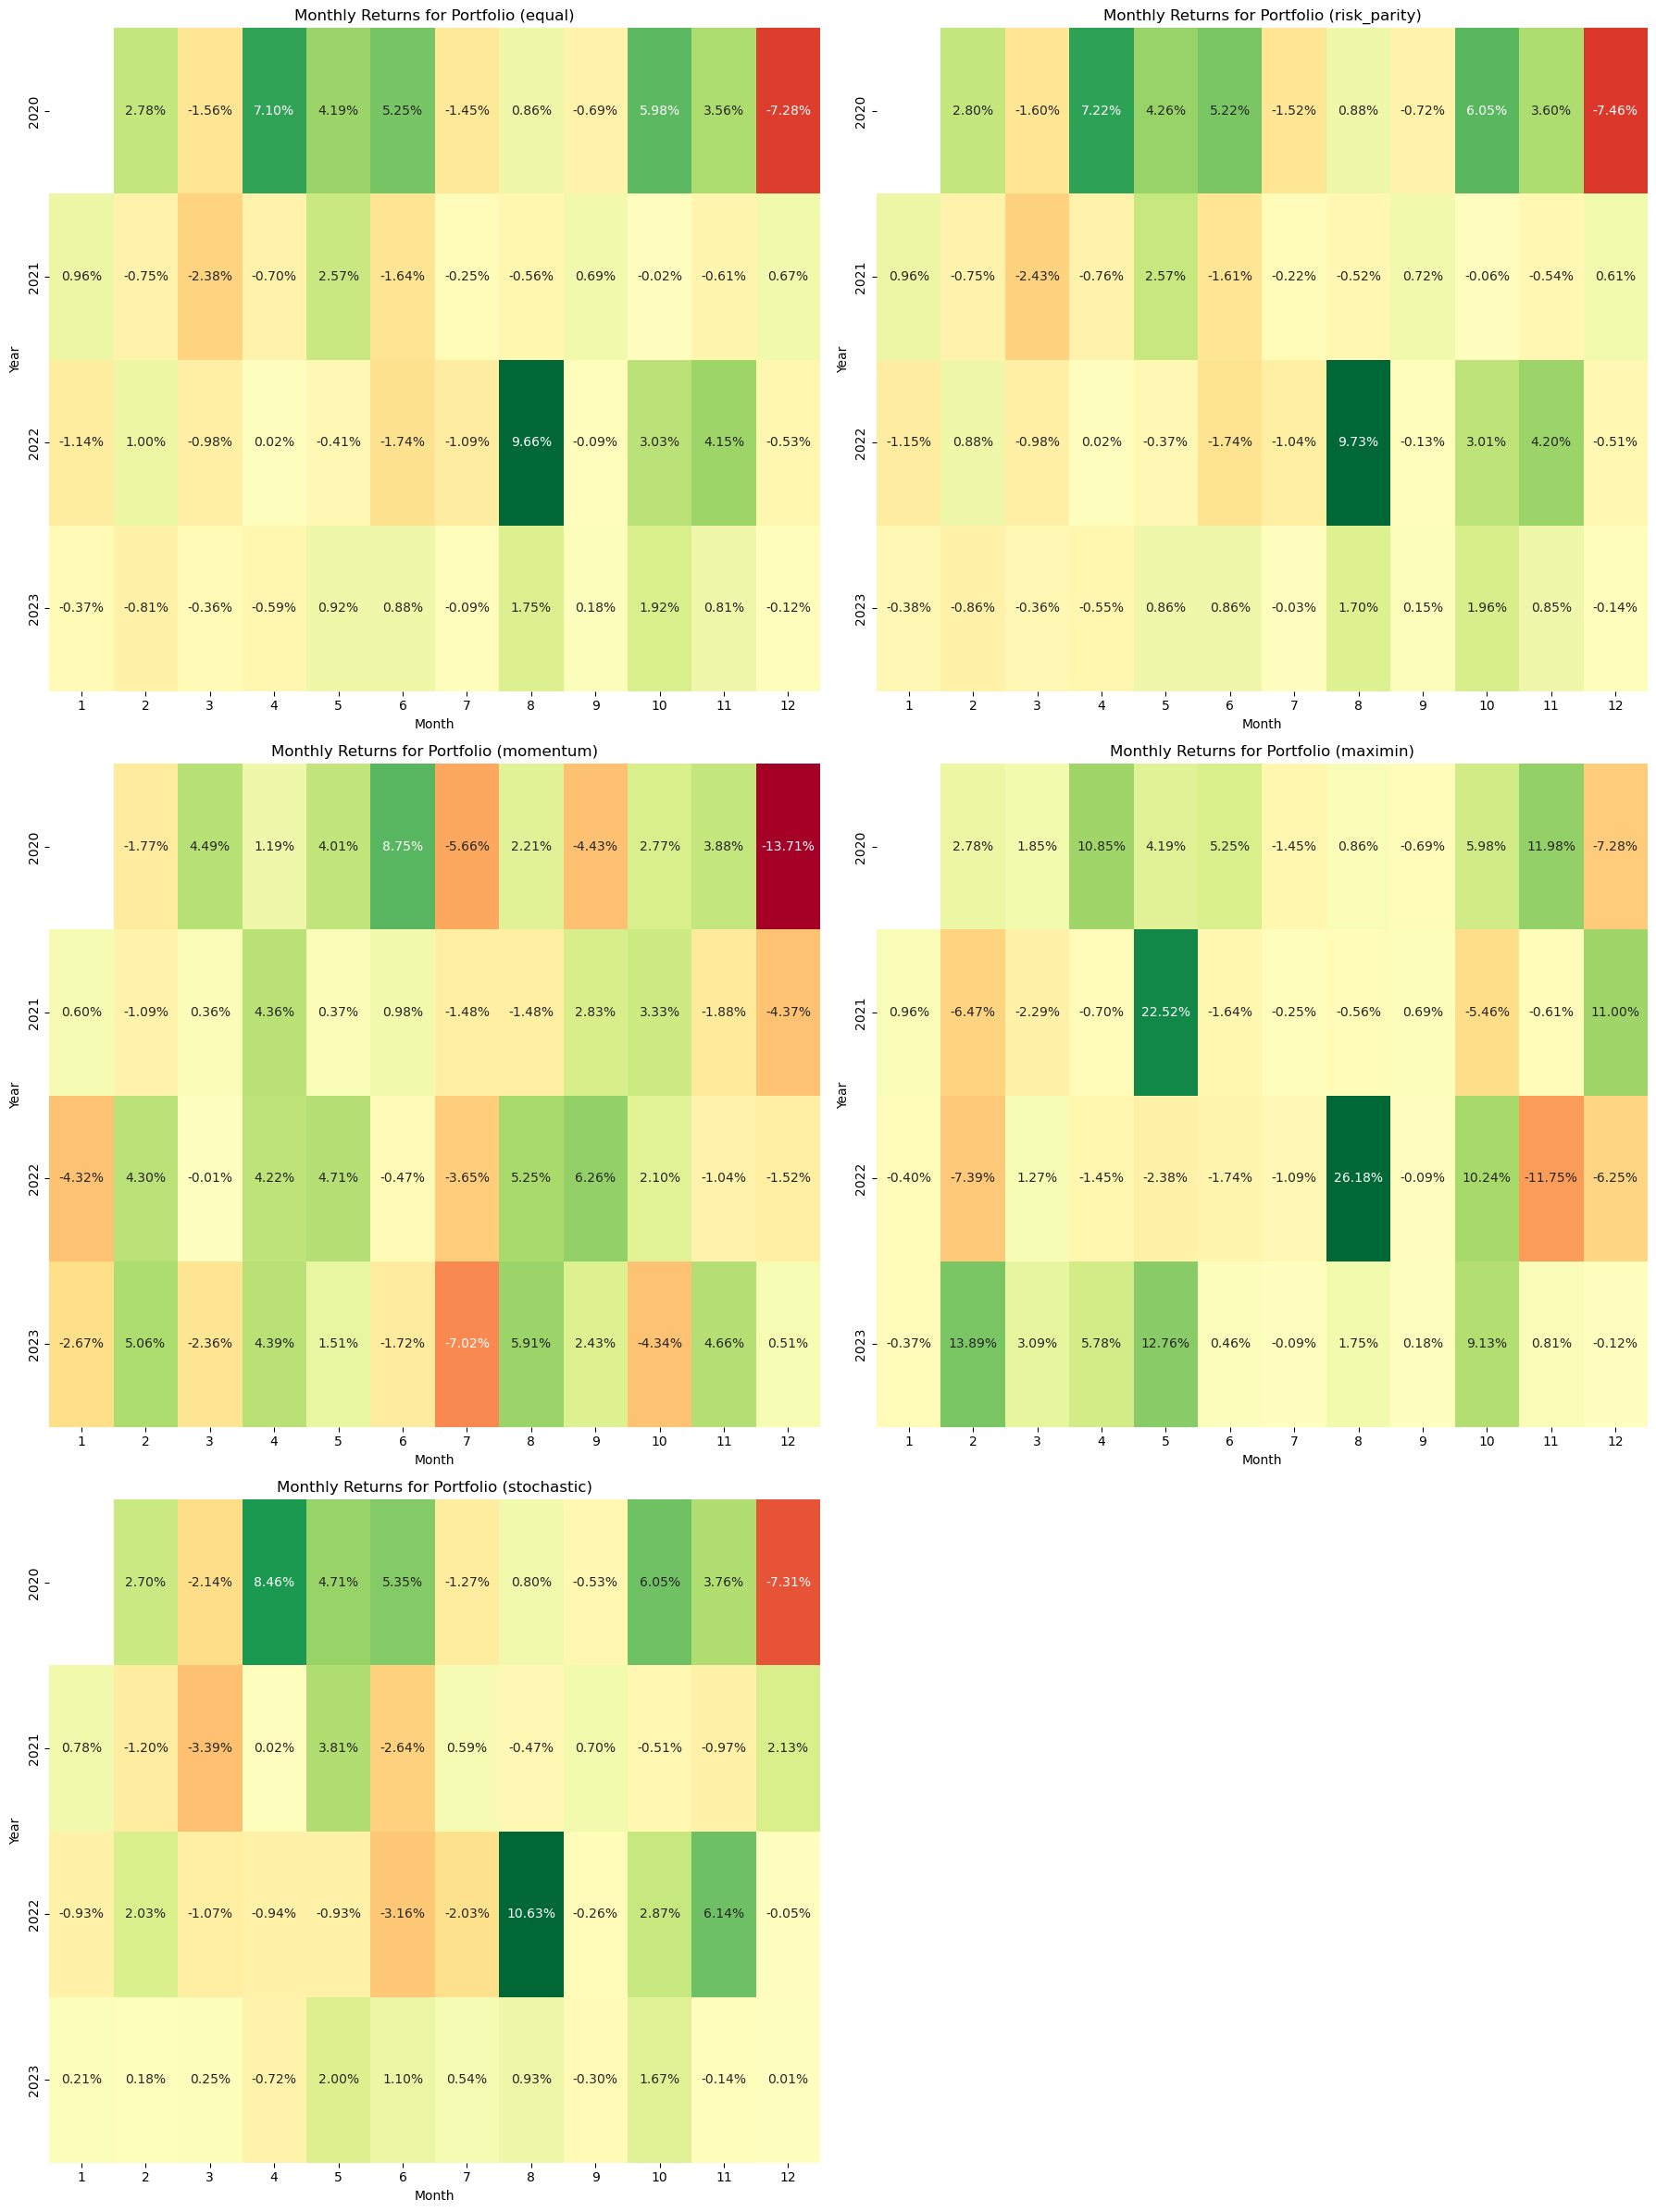

In [8]:
#con window size = 24, risultati ottimi con Random Forest
strategy = Factor_classes.RollingAPCAStrategy(returns, window_size=36, max_iterations=1000, transaction_cost=0.001, slippage=0.001)
index_cum_returns, portfolio_cum_returns = strategy.evaluate_strategies(index_returns)

In [9]:
index_test_rets = pd.DataFrame(index_cum_returns)
index_test_rets.rename(columns={'Open': 'Benchmark'}, inplace=True)

index_test_rets.head(3)

,Benchmark
Date,
2020-02-29,-0.013132
2020-03-31,-0.041379
2020-04-30,-0.256705


In [10]:
index_stats = Factor_classes.FinancialMetrics.summary_stats(index_test_rets)

index_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
Benchmark,0.0616,0.2548,0.1835,-0.3786,6.5755,0.0622,0.1144,0.1551,0.9912,0.1204,0.1672,0.1067,0.2562,-0.2875,0.9179,1,0,0,0,1.7226


In [11]:
portfolio_test_rets = pd.DataFrame(portfolio_cum_returns)

portfolio_test_rets.head(3)

,equal,risk_parity,momentum,maximin,stochastic
2020-02-29,0.027804,0.027961,-0.017709,0.027804,0.027040
2020-03-31,-0.015620,-0.015950,0.044888,0.018473,-0.021385
2020-04-30,0.070953,0.072181,0.011916,0.108527,0.084569


In [12]:
portfolio_stats = Factor_classes.FinancialMetrics.summary_stats(portfolio_test_rets, market=index_test_rets)

portfolio_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
equal,0.0822,0.0947,0.0494,0.7900,5.5874,0.0171,0.0297,0.0380,4.8068,0.5360,1.0436,0.3876,0.7949,-0.1310,2.7670,-0.1252,-0.4055,0.0867,-0.6087,3.3685
risk_parity,0.0820,0.0958,0.0508,0.7682,5.6437,0.0170,0.0303,0.0388,4.8104,0.5282,1.0141,0.3800,0.7737,-0.1332,2.7156,-0.1283,-0.3944,0.0870,-0.6111,3.4015
momentum,0.0588,0.1442,0.1064,-0.8064,4.3424,0.0529,0.0699,0.0880,1.1107,0.1941,0.2630,0.1650,0.3380,-0.1696,1.4779,-0.1430,-0.1956,0.0932,-0.8374,1.0802
maximin,0.2641,0.2508,0.1098,1.2350,5.0885,0.0703,0.0655,0.0880,3.7551,0.9084,2.0860,1.2970,3.3518,-0.1757,8.5630,-0.2216,-1.0284,0.1143,0.8831,1.9269
stochastic,0.0939,0.1076,0.0570,0.8167,4.8889,0.0300,0.0339,0.0462,3.1265,0.5775,1.1165,0.4177,0.9568,-0.1488,2.8301,-0.1181,-0.5262,0.0875,-0.4774,2.0372
